In [1]:
import pandas as pd

In [5]:
file_path = 'weatherAUS.csv'
Aus_weather = pd.read_csv(file_path)

In [6]:
Aus_weather.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [11]:
Aus_weather['Date'] = pd.to_datetime(Aus_weather['Date'])

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [12]:
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [13]:
Aus_weather['Season'] = Aus_weather['Date'].apply(get_season)
df_spring = Aus_weather[Aus_weather['Season'] == 'Spring']
df_summer = Aus_weather[Aus_weather['Season'] == 'Summer']
df_autumn = Aus_weather[Aus_weather['Season'] == 'Autumn']
df_winter = Aus_weather[Aus_weather['Season'] == 'Winter']

In [16]:
len(df_spring), len(df_summer), len(df_autumn), len(df_winter)

(38264, 36737, 35337, 35122)

In [88]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [89]:
def preprocess_weather_data(df):
    # Impute missing values for numerical columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    # Drop certain categorical columns
    df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Date', 'Season'], axis=1)

    # Impute missing values for remaining categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    # Encode categorical variables
    label_encoders = {}
    for column in cat_cols:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        label_encoders[column] = label_encoder

    return df, label_encoders
processed_weather_data, encoders = preprocess_weather_data(df_winter)

d:\Anaconda\envs\pytorch\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [90]:
processed_weather_data.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [91]:
X = processed_weather_data.drop(['RainTomorrow'], axis=1)
y = processed_weather_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [93]:
best_params = {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
logreg_pca = RandomForestClassifier(**best_params,random_state=42)
logreg_pca.fit(X_train_pca, y_train)
y_pred_pca = logreg_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
classification_rep_pca = classification_report(y_test, y_pred_pca)
print(classification_rep_pca)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      8472
           1       0.71      0.41      0.52      2065

    accuracy                           0.85     10537
   macro avg       0.79      0.69      0.72     10537
weighted avg       0.84      0.85      0.84     10537



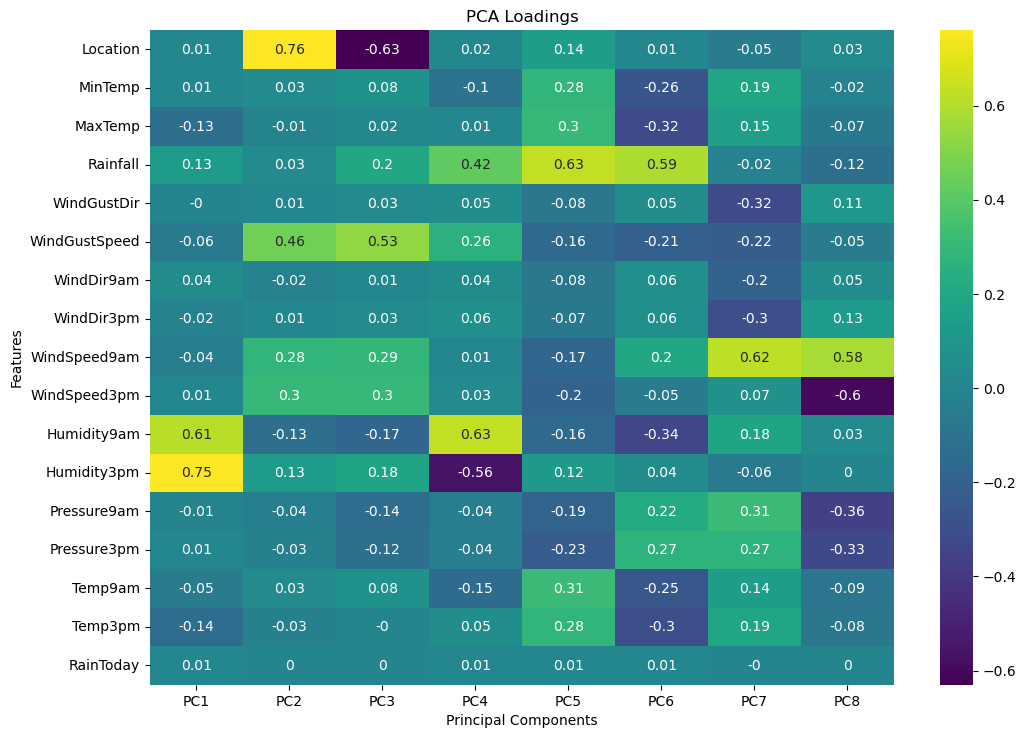

In [94]:
loadings = pca.components_
num_pc = pca.n_components_
pc_labels = ['PC'+str(i) for i in range(1, num_pc + 1)]
feature_labels = X.columns

# Create a DataFrame of loadings
df_loadings = pd.DataFrame(loadings.T, columns=pc_labels, index=feature_labels).round(2)

# Plotting the heatmap of loadings
plt.figure(figsize=(12, len(feature_labels)/2))
sns.heatmap(df_loadings, annot=True, cmap='viridis')
plt.title('PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

In [ ]:
df_loadings = pd.DataFrame(loadings, columns=feature_labels)

# Identifying dominant features for each principal component
dominant_features = {}
for i in range(num_pc):
    pc = 'PC' + str(i + 1)
    # Sort the loadings by absolute value and get the feature with highest loading
    dominant_feature = df_loadings.iloc[i].abs().idxmax()
    dominant_features[pc] = dominant_feature

dominant_features